<a href="https://colab.research.google.com/github/shishiradk/langgraph-chatbot/blob/main/Langgraph_chatboty_with_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install langgraph langsmith langchain langchain_groq langchain_community


In [29]:
from typing import Annotated
from typing_extensions import TypedDict


In [30]:
!pip install arxiv wikipedia

In [31]:
# Working with the tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun


## Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [32]:
wiki_tool.invoke("who is Albert Einstein")

'Page: Hans Albert Einstein\nSummary: Hans Albert Einstein (May 14, 1904 – July 26, 1973) was a Swiss-American engineer, the second child and first son of physicists Albert Einstein and Mileva Marić. He was a long-time professor of hydraulic engineering at the University of California, Berkeley.\nEinst'

In [33]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [34]:
tools=[wiki_tool]

In [35]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [36]:
from langgraph.graph import StateGraph,START,END

In [37]:
graph_builder = StateGraph(State)

In [38]:
from langchain_groq import ChatGroq

In [39]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

In [40]:
llm= ChatGroq(model_name="openai/gpt-oss-20b", api_key=GROQ_API_KEY)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ae48f267f80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ae48f267b00>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [41]:
llm_with_tools=llm.bind_tools(tools=tools)

In [42]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [43]:
from langgraph.prebuilt import ToolNode,tools_condition

In [44]:
graph_builder.add_node("chat-bot",chatbot)
graph_builder.add_edge(START,"chat-bot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chat-bot",
    tools_condition
)
graph_builder.add_edge("tools","chat-bot")
graph_builder.add_edge("chat-bot",END)

In [45]:
graph=graph_builder.compile()

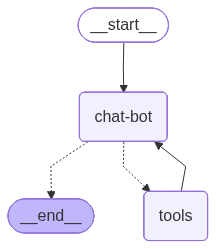

In [46]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [47]:
user_input="Hi there , my name is shishir"

events=graph.stream(
    {"messages":[("user",user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there , my name is shishir
================================== Ai Message ==================================

Hello Shishir! 👋 How can I help you today?
